# Linear Modelling Case Study

                                                                                                Naik_Sakshi_A1
                                                                                          Individual Assignment

# Introduction

In recent years, the bike-sharing industry has experienced significant growth, due to factors such as environmental sustainability, convenience, and health benefits. 

The Cook County Planning and Development Department, overseeing the Chicago metropolitan area, aims to leverage these trends by predicting daily bike rental volumes.

This analysis involves developing a machine learning model capable of forecasting the number of bike rentals on any given day, with a focus to understand the most affected factors for rental demand. 

The process has exploratory data analysis, data preprocessing, feature engineering, and model development.

By considering a Decision Tree Regressor, we aim to capture the nonlinear relationships and interactions between various factors and bike rental patterns, providing valuable insights for strategic planning and operational adjustments.

Missing values in training data
ID                         0
DateHour                   0
Temperature(F)             0
Humidity(%)                0
Wind speed (mph)           0
Visibility(miles)         63
DewPointTemperature(F)    51
Rainfall(in)               0
Snowfall(in)               0
SolarRadiation(MJ/m2)     80
Holiday                    0
FunctioningDay             0
RENTALS                    0
dtype: int64
Missing values in testing data
ID                         0
DateHour                   0
Temperature(F)             0
Humidity(%)                0
Wind speed (mph)           0
Visibility(miles)         13
DewPointTemperature(F)    16
Rainfall(in)               0
Snowfall(in)               0
SolarRadiation(MJ/m2)     26
Holiday                    0
FunctioningDay             0
dtype: int64
       Temperature(F)  Humidity(%)  Wind speed (mph)  Visibility(miles)  \
count     1638.000000  1638.000000       1638.000000        1638.000000   
mean        57.341880    59.029915  

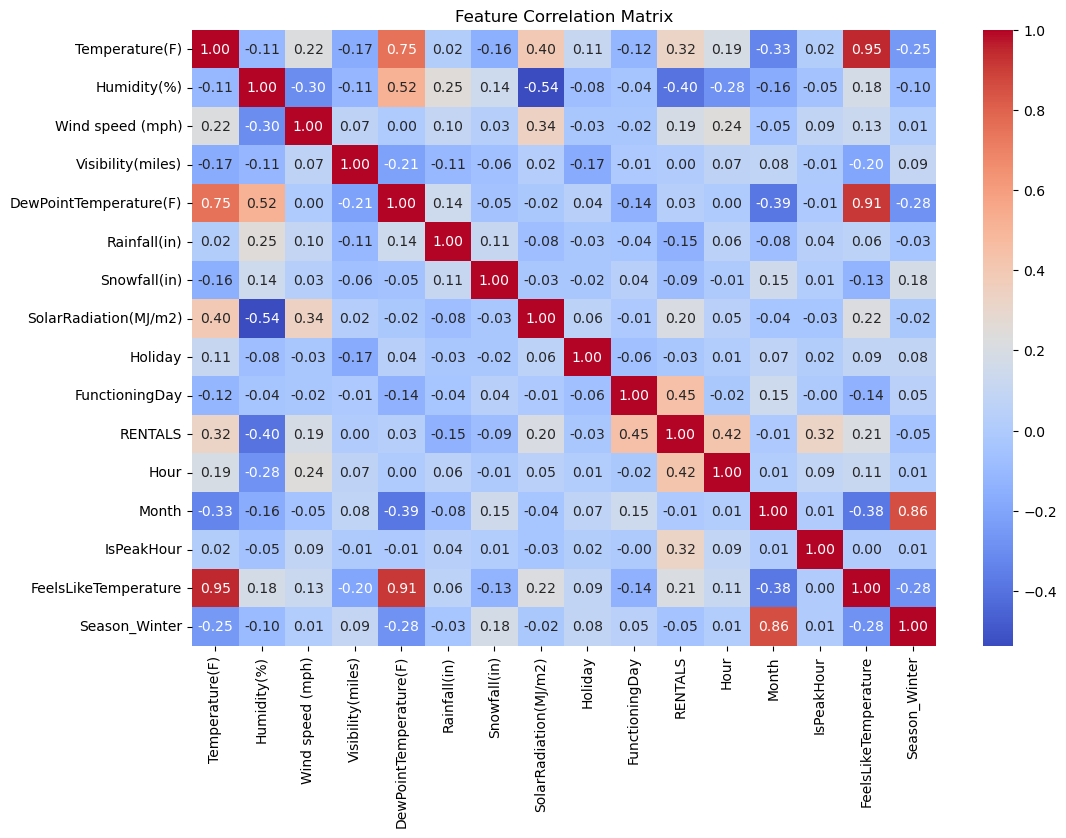

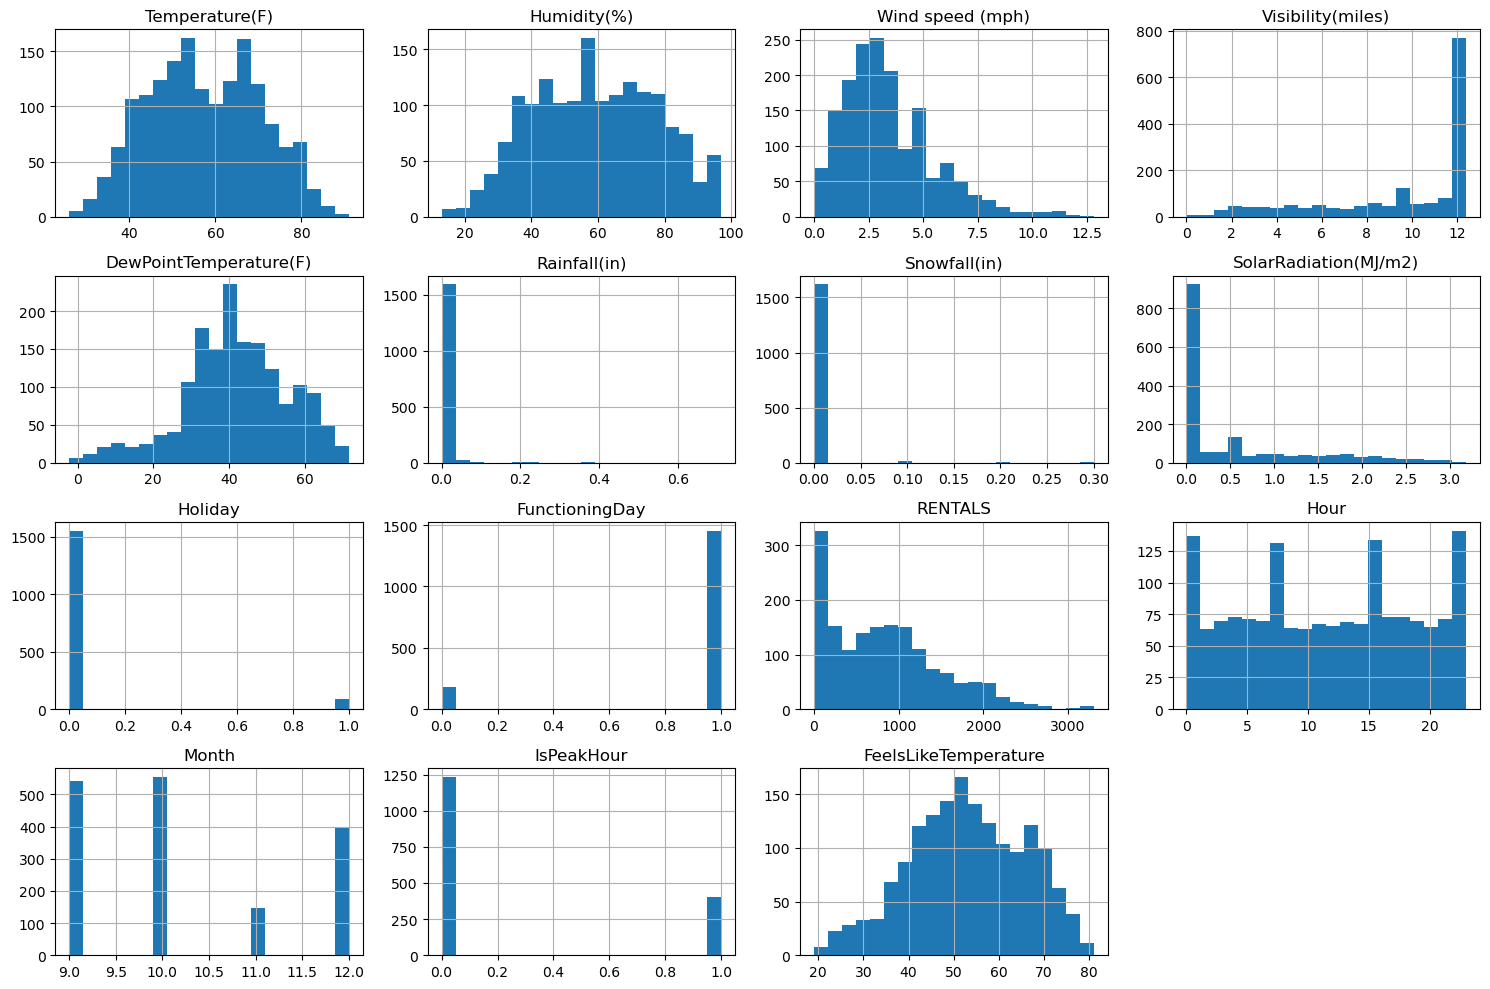

In [7]:
#Importing necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def parse_dates(date_str):
    try:
        #Try parsing the '%Y-%m-%d %H:%M:%S.%f' format
        return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S.%f', errors='raise')
    except ValueError:
        #Fall back to the '%Y-%m-%d %H:%M:%S' format
        return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S', errors='raise')

def process_features(data):
    #Imputing missing values
    data['Visibility(miles)'].fillna(data['Visibility(miles)'].mean(), inplace=True)
    data['DewPointTemperature(F)'].fillna(data['DewPointTemperature(F)'].mean(), inplace=True)
    data['SolarRadiation(MJ/m2)'].fillna(data['SolarRadiation(MJ/m2)'].mean(), inplace=True)
    
    #Convert 'Holiday' and 'FunctioningDay' to binary variables
    data['Holiday'] = data['Holiday'].replace({'No': 0, 'Yes': 1})
    data['FunctioningDay'] = data['FunctioningDay'].replace({'No': 0, 'Yes': 1})

    #Parse date
    data['DateHour'] = data['DateHour'].apply(parse_dates)
    
    #Get 'Hour' and 'Month' from the datetime
    data['Hour'] = data['DateHour'].dt.hour
    data['Month'] = data['DateHour'].dt.month
    data.drop('DateHour', axis=1, inplace=True)

    #Creating new features
    
    #Create IsPeakHour feature using Hour such that peak hours are 7-9 AM and 4-6 PM
    data['IsPeakHour'] = data['Hour'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 18) else 0)
    #Create FeelsLike feature
    data['FeelsLikeTemperature'] = data['Temperature(F)'] - 0.55 * (1 - data['Humidity(%)'] / 100) * (data['Temperature(F)'] - data['DewPointTemperature(F)'])
    #Create Season feature
    data['Season'] = data['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else ('Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else 'Fall')))
    data = pd.get_dummies(data, columns=['Season'], drop_first=True)
    return data

#Load the training dataset
train_data = pd.read_excel('./datasets/train.xlsx')
#Load the test dataset
test_data = pd.read_excel('./datasets/test.xlsx')

#Check for missing values in both dataset
print("Missing values in training data")
print(train_data.isnull().sum())
print("Missing values in testing data")
print(test_data.isnull().sum())

#Process features
train_data = process_features(train_data)
test_data = process_features(test_data)

#Summary of the dataset
description = train_data.describe()
print(description)

#Generate descriptive statistics 
desc_stats=train_data.describe()
print(desc_stats)

#Drop ID column
train_data.drop('ID', axis=1, inplace=True)

#Generate coorelation matrix
corr_matrix = train_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Matrix')
plt.show()

#Generate Histogram
train_data.hist(figsize=(15,10),bins=20)
plt.tight_layout()
plt.show()

#Drop the ID and rental column
X = train_data.drop(columns=['RENTALS'])
y = train_data['RENTALS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Exploratory Data Analysis And Data Preprocessing

The exploratory data analysis gave critical insights into bike rental patterns and the underlying factors affecting them. 
The dataset includes variables like temperature, humidity, solar radiation,{key predictors}, wind speed, visibility, dew point temperature, rainfall, snowfall, and operational factors like holidays and functioning days. 

Key observations from the EDA include:
Missing Values: The dataset contained missing values in 'Visibility(miles)', 'DewPointTemperature(F)', and 'SolarRadiation(MJ/m2)', indicating occasional gaps in weather data collection. These were addressed by imputing the milling values with mean values.

Weather Conditions: The analysis of temperature, humidity, and solar radiation distributions suggested a varied relationship between weather conditions and bike rental volumes. 
For example, higher temperatures and moderate humidity levels are likely associated with increased rentals, reflecting favorable biking conditions.

Temporal Patterns: The inclusion of hour and month variables led to identification of temporal patterns in bike rental demand. 
Peak hours and months highlighted the influence of daily commuting needs and seasonal variations on rental volumes.This suggests the importance of adjusting bike availability and marketing efforts in response to these predictable fluctuations.

# Feature Engineering 

Feature engineering played a pivotal role in enhancing the model's predictive accuracy by introducing new variables that summarizes crucial determinants of bike rental demand.

IsPeakHour: This feature is engineered to identify high-demand periods during typical commuting hours (7-9 AM and 4-6 PM), reflecting the significant impact of work-related travel patterns on bike rental volumes.
By distinguishing these peak times, the model can more accurately predict demand surges, facilitating better resource allocation and service provision.

FeelsLikeTemperature: Recognizing that user comfort and the recognized temperature significantly influence rental decisions, this feature combines actual temperature readings with humidity levels to represent how outdoor conditions are likely felt by users. This approach enables the model to account for the effects of environmental conditions on biking preferences, leading to more accurate demand predictions.

Season: By categorizing the year into distinct seasons, this feature captures the seasonal variability in weather conditions and its consequent impact on bike rental patterns. This segmentation allows the model to adjust its predictions based on seasonal trends, keeping in mind the influence of weather on outdoor 

In [8]:
#Initializing models
lr = LinearRegression()
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1)
elastic_net = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
knn = KNeighborsRegressor(n_neighbors=5)
decision_tree = DecisionTreeRegressor(max_depth=5)

#Training and evaluating Linear Regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

#Training and evaluating Lasso
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

#Training and evaluating Ridge
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

#Training and evaluating Elastic Net
elastic_net.fit(X_train, y_train)
y_pred_elastic_net = elastic_net.predict(X_test)
rmse_elastic_net = np.sqrt(mean_squared_error(y_test, y_pred_elastic_net))
r2_elastic_net = r2_score(y_test, y_pred_elastic_net)

#Training and evaluating KNN
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

#Training and evaluating Decision Tree
decision_tree.fit(X_train, y_train)
y_pred_decision_tree = decision_tree.predict(X_test)
rmse_decision_tree = np.sqrt(mean_squared_error(y_test, y_pred_decision_tree))
r2_decision_tree = r2_score(y_test, y_pred_decision_tree)

#Compiling the results
results = [
    {'Model': 'Linear Regression', 'RMSE': rmse_lr, 'R2 Score': r2_lr},
    {'Model': 'Lasso', 'RMSE': rmse_lasso, 'R2 Score': r2_lasso},
    {'Model': 'Ridge', 'RMSE': rmse_ridge, 'R2 Score': r2_ridge},
    {'Model': 'Elastic Net', 'RMSE': rmse_elastic_net, 'R2 Score': r2_elastic_net},
    {'Model': 'KNN', 'RMSE': rmse_knn, 'R2 Score': r2_knn},
    {'Model': 'Decision Tree', 'RMSE': rmse_decision_tree, 'R2 Score': r2_decision_tree}
]

#Displaying results sorted by RMSE
print("Untuned model results: ")
results_df = pd.DataFrame(results)
results_df.sort_values(by='RMSE', ascending=True, inplace=True)
print(results_df)

Untuned model results: 
               Model        RMSE  R2 Score
5      Decision Tree  354.738619  0.698225
3        Elastic Net  397.526221  0.621036
1              Lasso  398.105798  0.619930
2              Ridge  398.301657  0.619556
0  Linear Regression  398.362366  0.619440
4                KNN  509.351458  0.377840


/Users/sakshinaik/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.700e+07, tolerance: 5.027e+04
  model = cd_fast.enet_coordinate_descent(


# Hyperparameter Tuning

In [9]:
#Elastic Net Tuning
elastic_net_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', SGDRegressor(max_iter=1000, tol=1e-3, penalty='elasticnet'))
])
elastic_net_params = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1],
    'elasticnet__l1_ratio': [0.15, 0.5, 0.85]
}
grid_search_elastic_net = GridSearchCV(elastic_net_pipeline, elastic_net_params, cv=5, scoring='neg_mean_squared_error')
grid_search_elastic_net.fit(X_train, y_train)

best_elastic_net_model = grid_search_elastic_net.best_estimator_
print("Best Elastic Net Params:", grid_search_elastic_net.best_params_)

#Decision Tree Tuning
decision_tree_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_decision_tree = GridSearchCV(DecisionTreeRegressor(), decision_tree_params, cv=5, scoring='neg_mean_squared_error')
grid_search_decision_tree.fit(X_train, y_train)

best_decision_tree_model = grid_search_decision_tree.best_estimator_
print("Best Decision Tree Params:", grid_search_decision_tree.best_params_)

#Lasso Tuning
lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}
grid_search_lasso = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, y_train)

best_lasso_model = grid_search_lasso.best_estimator_
print("Best Lasso Params:", grid_search_lasso.best_params_)

Best Elastic Net Params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.15}
Best Decision Tree Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}


/Users/sakshinaik/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.068e+07, tolerance: 3.996e+04
  model = cd_fast.enet_coordinate_descent(
/Users/sakshinaik/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.840e+07, tolerance: 4.132e+04
  model = cd_fast.enet_coordinate_descent(
/Users/sakshinaik/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Best Lasso Params: {'alpha': 0.1}


/Users/sakshinaik/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.161e+04, tolerance: 4.137e+04
  model = cd_fast.enet_coordinate_descent(
/Users/sakshinaik/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.959e+04, tolerance: 3.943e+04
  model = cd_fast.enet_coordinate_descent(
/Users/sakshinaik/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

# Model Development and Final Model Selection

For model development in bike rental prediction, multiple regression models were initialized and evaluated, including Linear Regression, Lasso, Ridge, Elastic Net, KNeighborsRegressor (KNN), and Decision Tree Regressor.

Each model was trained on a training dataset (X_train, y_train) and then evaluated on a testing dataset (X_test, y_test) using Root Mean Square Error (RMSE) and R^2 Score as performance metrics. 

The Decision Tree Regressor demonstrated the best performance with the lowest RMSE and the highest R^2 Score, indicating its higher predictive accuracy and efficiency.

Root Mean Square Error (RMSE): Lower RMSE values indicate better performance, making it a primary metric for assessing how well the model can predict the number of bike rentals on a given day. 
The emphasis on RMSE is due to its sensitivity to outliers, which helps in identifying models that are not only accurate on average but also capable of handling extreme cases effectively.

R^2 Score (Coefficient of Determination): A higher R^2 score means the model explains a larger portion of the variance in rental data, indicating a better fit to the observed data. This metric is particularly important for stakeholders to assess the model's overall effectiveness and its ability to capture the underlying dynamics of bike rental demand.

Feature Importance: While not a direct performance metric, understanding the importance of different features used by the model (such as weather conditions, time of the day, and holidays) is crucial for interpreting the model's predictions and making informed decisions. 
Models like Decision Trees inherently provide insights into feature importance, which can be crucial for identifying key drivers of bike rental demand and for strategic planning purposes.

In [10]:
#Preparing test data for prediction
X_test = test_data.drop(columns=['ID'])

#Using the final model to make predictions on the test dataset
test_data['RENTALS'] = best_decision_tree_model.predict(X_test)

#Saving the predictions to a CSV file
test_data[['ID', 'RENTALS']].to_csv('finalprediction.csv', index=False)

# Conclusion

Dynamic Fleet Management: Given the predictive insights on peak hours and the of weather conditions, it is recommended that Cook County implements a dynamic fleet management system. 
This system should be capable of reallocating bikes to high-demand areas during peak hours and ensuring adequate supply during favorable weather conditions. 
During times predicted to have lower rentals, such as periods of low solar radiation which may correspond to less favorable weather, the department could reduce the number of bikes in circulation to minimize operational costs.

Targeted Marketing and Incentives: The department could develop targeted marketing campaigns and incentives that encourage bike usage during off-peak hours and non-ideal weather conditions, as indicated by the model's insights. For example, offering discounts or promotions during these periods could help maintain a steady rental volume throughout the day and across different seasons. Additionally, focusing on the benefits of bike-sharing related to physical fitness could attract users who are motivated by health considerations, regardless of the time of day or weather conditions.

# References



OpenAI. (2022). ChatGPT (Dec 20 version) [Large language model]. Retrieved from https://chat.openai.com/

